# What is `torch.nn` really?

Some notes while following [PyTorch tutorial](https://docs.pytorch.org/tutorials/beginner/nn_tutorial.html).

## Data loading
Since the dataset is available from `torchvision`, we can directly download it and then wrap into into `DataLoader`, that takes care of minibatching and shuffling the samples.

In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

validation_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Feature batch shape: torch.Size([15, 1, 28, 28])
Label batch shape: torch.Size([15])


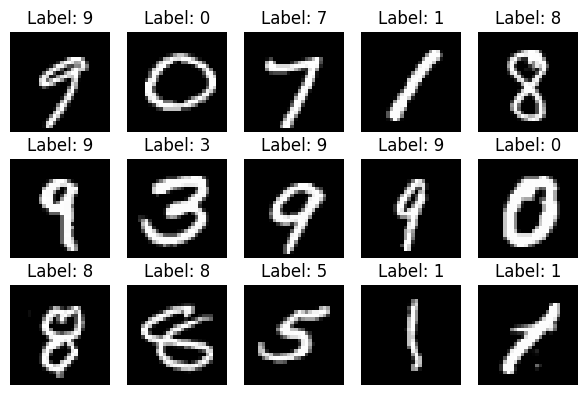

In [2]:
import matplotlib.pylab as plt
from torch.utils.data import DataLoader
import numpy as np

subplots_grid = (3, 5)
n_elements_in_batch = subplots_grid[0] * subplots_grid[1]

train_dataloader = DataLoader(training_data, batch_size=n_elements_in_batch, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Label batch shape: {train_labels.size()}")

fig, axes = plt.subplots(*subplots_grid, figsize=(6, 4))
for batch_idx in range(n_elements_in_batch):
    i, j = np.unravel_index(batch_idx, subplots_grid)
    axes[i, j].imshow(train_features[batch_idx].squeeze(), cmap="gray")
    axes[i, j].set_title(f"Label: {train_labels[batch_idx]}")
    axes[i, j].axis("off")
fig.tight_layout()
plt.show()

## Neural network from scratch

In this section we are gonna use raw tensors to create weights and biases for a simple linear model. Those tensors are regular multi-dimensional linear objects with one addition: PyTorch knows that they require a gradient, so PyTorch records all of the operations on the tensor so it can calculate the gradient later.

The weights are initialized using Xavier initialization ($\frac{1}{\sqrt{n}}$).

In [3]:
import torch 

def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(x, weights, bias):
    x = x.view(x.size(0), -1)  # flatten
    return log_softmax(x @ weights + bias)

dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
# if we set requires_grad_ to True, PyTorch will track all operations on the tensor
# and the normalization operation will count, so backward() will fail if we perform something else on the weights
weights = torch.randn(784, 10) / np.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

samples, labels = next(iter(dataloader))
preds = model(samples, weights, bias)

print(preds[0], preds.shape)

tensor([-2.4415, -1.9916, -2.6939, -3.1501, -1.8107, -2.1830, -2.4445, -2.0663,
        -2.4667, -2.3915], grad_fn=<SelectBackward0>) torch.Size([64, 10])


**Note**: predictions contain not only the tensor values, but also a gradient function. Later it is used for back-propagation.

The negative log-likelihood can be used as a loss function:

In [4]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss = nll(preds, labels)
print(loss)

tensor(2.5001, grad_fn=<NegBackward0>)


Once again, loss function returned the tensor with its gradient.

Now it is time to implement a function that assess the accuracy of hte model. One of the ways this can be implemented is if the largest value among prediction vectors matches the true label:

In [5]:
def accuracy(output, labels):
    best_predictions = output.argmax(dim=1)
    return (best_predictions == labels).float().mean()

# check the prediction accuracy of the model
test_dataloader = DataLoader(validation_data, batch_size=64, shuffle=True)
test_samples, test_labels = next(iter(test_dataloader))
preds = model(test_samples, weights, bias)
print(accuracy(preds, test_labels))

tensor(0.0469)


The prediction accuracy is too low to say that our NN is able to predict something.

Now we can run a simple training loop:
- sample a mini-batch and labels;
- use the model to make predictions;
- calculate the loss;
- use the loss to update the gradients of the model.

In [6]:
learning_rate = 0.1
epochs = 10

dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
dataiter = iter(dataloader)

for epoch in range(epochs):
    batch, labels = next(dataiter)

    preds = model(batch, weights, bias)
    loss = nll(preds, labels)

    # calculate the gradients
    print(epoch)
    loss.backward()
    # if we don't do this, the gradients operationts will be recorded for our next calculation of the gradient
    with torch.no_grad():
        weights -= weights.grad * learning_rate
        bias -= bias.grad * learning_rate
        # zero the gradients after updating
        weights.grad.zero_()
        bias.grad.zero_()

0
1
2
3
4
5
6
7
8
9


Now let's check the accuracy:

In [7]:
# check the prediction accuracy of the model
test_dataloader = DataLoader(validation_data, batch_size=64, shuffle=True)
test_samples, test_labels = next(iter(test_dataloader))
preds = model(test_samples, weights, bias)
print(accuracy(preds, test_labels))

tensor(0.6719)


Works fine! We achieved 60% accuracy on average.

## Using `torch.nn.functional`
Now the code will be refactored, so it does the same as before, but using PyTorch `nn` classes to make it more concise and flexible.

To define NN architechture we subclass `nn.Module` (able to keep track of state).

In [8]:
from torch import nn
from torch.nn import functional as F

class MnistLogistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / np.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten
        return x @ self.weights + self.bias

Previously in the training loop there was some work that had to be done manually: parameters updates and gradients resets. Now `model.parameters()` and `model_zero.grad()` take care of that:

In [9]:
def train(model, epochs, learning_rate):
    dataiter = iter(dataloader)
    for _ in range(epochs):
        batch, labels = next(dataiter)

        preds = model(batch)
        loss = nll(preds, labels)

        # calculate the gradients
        loss.backward()
        with torch.no_grad():
            for p in model.parameters():
                p -= p.grad * learning_rate
            model.zero_grad()
        
model = MnistLogistic()
train(model, epochs=100, learning_rate=0.1)

# check the prediction accuracy of the model
test_dataloader = DataLoader(validation_data, batch_size=64, shuffle=True)
test_samples, test_labels = next(iter(test_dataloader))
preds = model(test_samples)
print(accuracy(preds, test_labels))


tensor(0.6719)


## Refactor using `nn.linear`
Further refactoring will allow us to get rid of manually defined weights and biases: we will use PyTorch class `nn.Linear` instead.

In [10]:
class MnistLogistic2(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten(end_dim=-1)
        self.linear = nn.Linear(784, 10)

    def forward(self, x):
        return self.linear(self.flatten(x))
    
model2 = MnistLogistic2()
train(model2, epochs=100, learning_rate=0.1)
preds = model2(test_samples)
print(accuracy(preds, test_labels))

tensor(0.6875)


## Refactor using `torch.optim`
Instead of manually updating parameters we can utilize `torch.optim`, that was created especially for that.

In [11]:
from torch import optim

def train2(model, epochs, opt):
    dataiter = iter(dataloader)
    for _ in range(epochs):
        batch, labels = next(dataiter)

        preds = model(batch)
        loss = nll(preds, labels)

        # calculate the gradients
        loss.backward()
        # updates NN parameters
        opt.step()
        # zeroes gradients
        opt.zero_grad()

def get_model():
    model = MnistLogistic2()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    return model, optimizer

model2, opt = get_model()
train2(model2, epochs=100, opt=opt)
preds = model2(test_samples)
print(accuracy(preds, test_labels))

tensor(0.6250)


## Validation and futher refactoring
If we want to go through a similar process twice: calculating the loss for both the training and validation sets, it makes sense to define a function `loss_batch`, which computes the loss for one batch.

In [12]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    # calculate loss
    loss = loss_func(model(xb), yb)

    if opt is not None:
        # propagate gradients
        loss.backward()
        # update parameters
        opt.step()
        # zeroes gradients
        opt.zero_grad()

    logits = model(xb)
    with torch.no_grad():
        pred = logits.argmax(1)
        correct = (pred == yb).sum().item()

    n = yb.size(0)
    return loss.item(), n, correct

def train(model, loss_func, opt, train_dl, valid_dl, epochs=5):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            outs = [loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            losses, ns, corrects = zip(*outs)
            val_loss = sum(l*n for l, n in zip(losses, ns)) / sum(ns)
            val_acc  = sum(corrects) / sum(ns)          # 0..1     

        print(f"epoch {epoch}: val_loss={val_loss:.3f}, val_acc={val_acc:.3f}")

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

Now all the process can be run in 3 lines of code:

In [13]:
model, opt = get_model()
loss_func = F.cross_entropy
train_dl, valid_dl = get_data(training_data, validation_data, 64)
train(model, loss_func, opt, train_dl, valid_dl, 5)

epoch 0: val_loss=0.338, val_acc=0.907
epoch 1: val_loss=0.307, val_acc=0.915
epoch 2: val_loss=0.297, val_acc=0.919
epoch 3: val_loss=0.290, val_acc=0.919
epoch 4: val_loss=0.283, val_acc=0.920


## Switching to CNN
Since now the model is abstracted from optimizaer and from training/validation data, we should be able to easily replace it with another one and train it.
Let's define the network architechture with 3 convolution layers.

In [14]:
class MnistCnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.unflatten = nn.Unflatten(-1, (1, 28, 28))
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(64, 10)

    def forward(self, x):
        if x.dim() == 2:
            x = self.unflatten(x)   # -> [1, 28, 28]
        x = self.features(x)        # -> [64, 4, 4]
        x = self.pool(x).flatten(1) # -> [64]
        return self.classifier(x)   # -> logits [10]

model = MnistCnn()
loss_func = F.cross_entropy
opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
train_dl, valid_dl = get_data(training_data, validation_data, 64)

train(model, loss_func, opt, train_dl, valid_dl, 5)

epoch 0: val_loss=0.139, val_acc=0.959
epoch 1: val_loss=0.111, val_acc=0.967
epoch 2: val_loss=0.082, val_acc=0.974
epoch 3: val_loss=0.063, val_acc=0.981
epoch 4: val_loss=0.069, val_acc=0.979
